In [5]:
# 1. 환경 설정 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 데이터 로드
try:
    df = pd.read_csv('../../data/secom.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")

Data loaded successfully.


In [6]:
# 2. 데이터 기본 정보 확인

# 데이터 크기
print(f'행(샘플) 수: {df.shape[0]}')
print(f'열(특성) 수: {df.shape[1]}')

# 컬럼 정보
print(f'컬럼 목록: {df.columns.tolist()[:10]}...')  # 처음 10개 컬럼만 출력
print(f'컬럼 갯수: {len(df.columns)}')
print(f'컬럼 타입:\n{df.dtypes.value_counts()}')

# 메모리 사용량 (MB 단위. 너무 클경우 샘플링 또는 chunking 고려)
memory_usage = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f'메모리 사용량: {memory_usage:.2f} MB')

행(샘플) 수: 1567
열(특성) 수: 592
컬럼 목록: ['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8']...
컬럼 갯수: 592
컬럼 타입:
float64    590
object       1
int64        1
Name: count, dtype: int64
메모리 사용량: 7.17 MB


In [22]:
# 3. 타겟 변수 분석 (Pass/Fail)

# object 타입 컬럼 확인 
object_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f'object 타입 컬럼: {object_cols}') # Time

last_col = df.columns[-1]
print(f'last 컬럼: {last_col}') # Pass/Fail 발견

target_col = last_col

# 타겟 변수 값 종류 확인
print(f'타겟 변수 값 종류: {df[target_col].unique()}') # [-1  1]

# 타겟 변수 값 분포 확인
print(f'타겟 변수 값 분포:\n{df[target_col].value_counts()}')
print(f'타겟 변수 비율:\n{df[target_col].value_counts(normalize=True)}') # 0.066369

# 결론 : 클래스 불균형 심함 -> accuracy만 가지고 모델 평가하지 말 것 (recall, precision, f1-score 등도 고려)




object 타입 컬럼: ['Time']
last 컬럼: Pass/Fail
타겟 변수 값 종류: [-1  1]
타겟 변수 값 분포:
Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64
타겟 변수 비율:
Pass/Fail
-1    0.933631
 1    0.066369
Name: proportion, dtype: float64


In [24]:
# 4. 결측치 분석
total_cells = df.shape[0] * df.shape[1]
total_missing = df.isnull().sum().sum()
missing_percentage = (total_missing / total_cells) * 100
print(f'전체 셀 수: {total_cells}')
print(f'결측치 셀 수: {total_missing}')
print(f'결측치 비율: {missing_percentage:.2f}%') # 4.52%

# 컬럼별 결측치 개수 및 비율
missing_per_column = df.isnull().sum()
print(f'컬럼별 결측치 개수:\n{missing_per_column[missing_per_column > 0]}')

# 결론 : 결측치 -> 중앙값으로 대체

전체 셀 수: 927664
결측치 셀 수: 41951
결측치 비율: 4.52%
컬럼별 결측치 개수:
0       6
1       7
2      14
3      14
4      14
       ..
585     1
586     1
587     1
588     1
589     1
Length: 538, dtype: int64


In [25]:
# 5. 특성(Feature) 기본 통계
features = df.drop(columns=[target_col])
print(f'특성 개수: {features.shape[1]}')

# 수치형 특성만 선택
numeric_features = features.select_dtypes(include=[np.number])

# 기술 통계량
print(numeric_features.describe()) 

# 상수 특성 확인 (모든 값이 같은 컬럼 = 쓸모없음)
constant_features = []
for col in numeric_features.columns:
    if numeric_features[col].nunique() <= 1:
        constant_features.append(col)

print(f'상수 특성: {constant_features}') # ['5', '13', '42', '49', '52', '69', '97', '141', '149', '178', '179', '186', '189', '190', '191', '192', '193', '194', '226', '229', '230', '231', '232', '233', '234', '235', '236', '237', '240', '241', '242', '243', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '276', '284', '313', '314', '315', '322', '325', '326', '327', '328', '329', '330', '364', '369', '370', '371', '372', '373', '374', '375', '378', '379', '380', '381', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '414', '422', '449', '450', '451', '458', '461', '462', '463', '464', '465', '466', '481', '498', '501', '502', '503', '504', '505', '506', '507', '508', '509', '512', '513', '514', '515', '528', '529', '530', '531', '532', '533', '534', '535', '536', '537', '538']

# 스케일 범위 확인

# 특성별 최소/최대값
ranges = numeric_features.max() - numeric_features.min()
ranges_clean = ranges.dropna()


print(f"   최소 범위: {ranges_clean.min():.2f}")
print(f"   최대 범위: {ranges_clean.max():.2f}")
scale_diff = ranges_clean.max() / ranges_clean.min() if ranges_clean.min() > 0 else float('inf')
print(f"   범위 차이: {scale_diff:.2f}배")

# 결론 : 상수값 특성제거, 스케일 차이가 무한대(inf) -> 스케일링 필요

특성 개수: 591
                 0            1            2            3            4  \
count  1561.000000  1560.000000  1553.000000  1553.000000  1553.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.621787    80.407705    29.513152   441.691640    56.355540   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.260000  2452.247500  2181.044400  1081.875800     1.017700   
50%    3011.490000  2499.405000  2201.066700  1285.214400     1.316800   
75%    3056.650000  2538.822500  2218.055500  1591.223500     1.525700   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

            5            6            7            8            9  \
count  1553.0  1553.000000  1558.000000  1565.000000  1565.000000   
mean    100.0   101.112908     0.121822     1.462862    -0.000841   
std       0.0     6.237214     0.008961     0.073897     0.015116   
min     100.0    82.131100     0.000000     1.

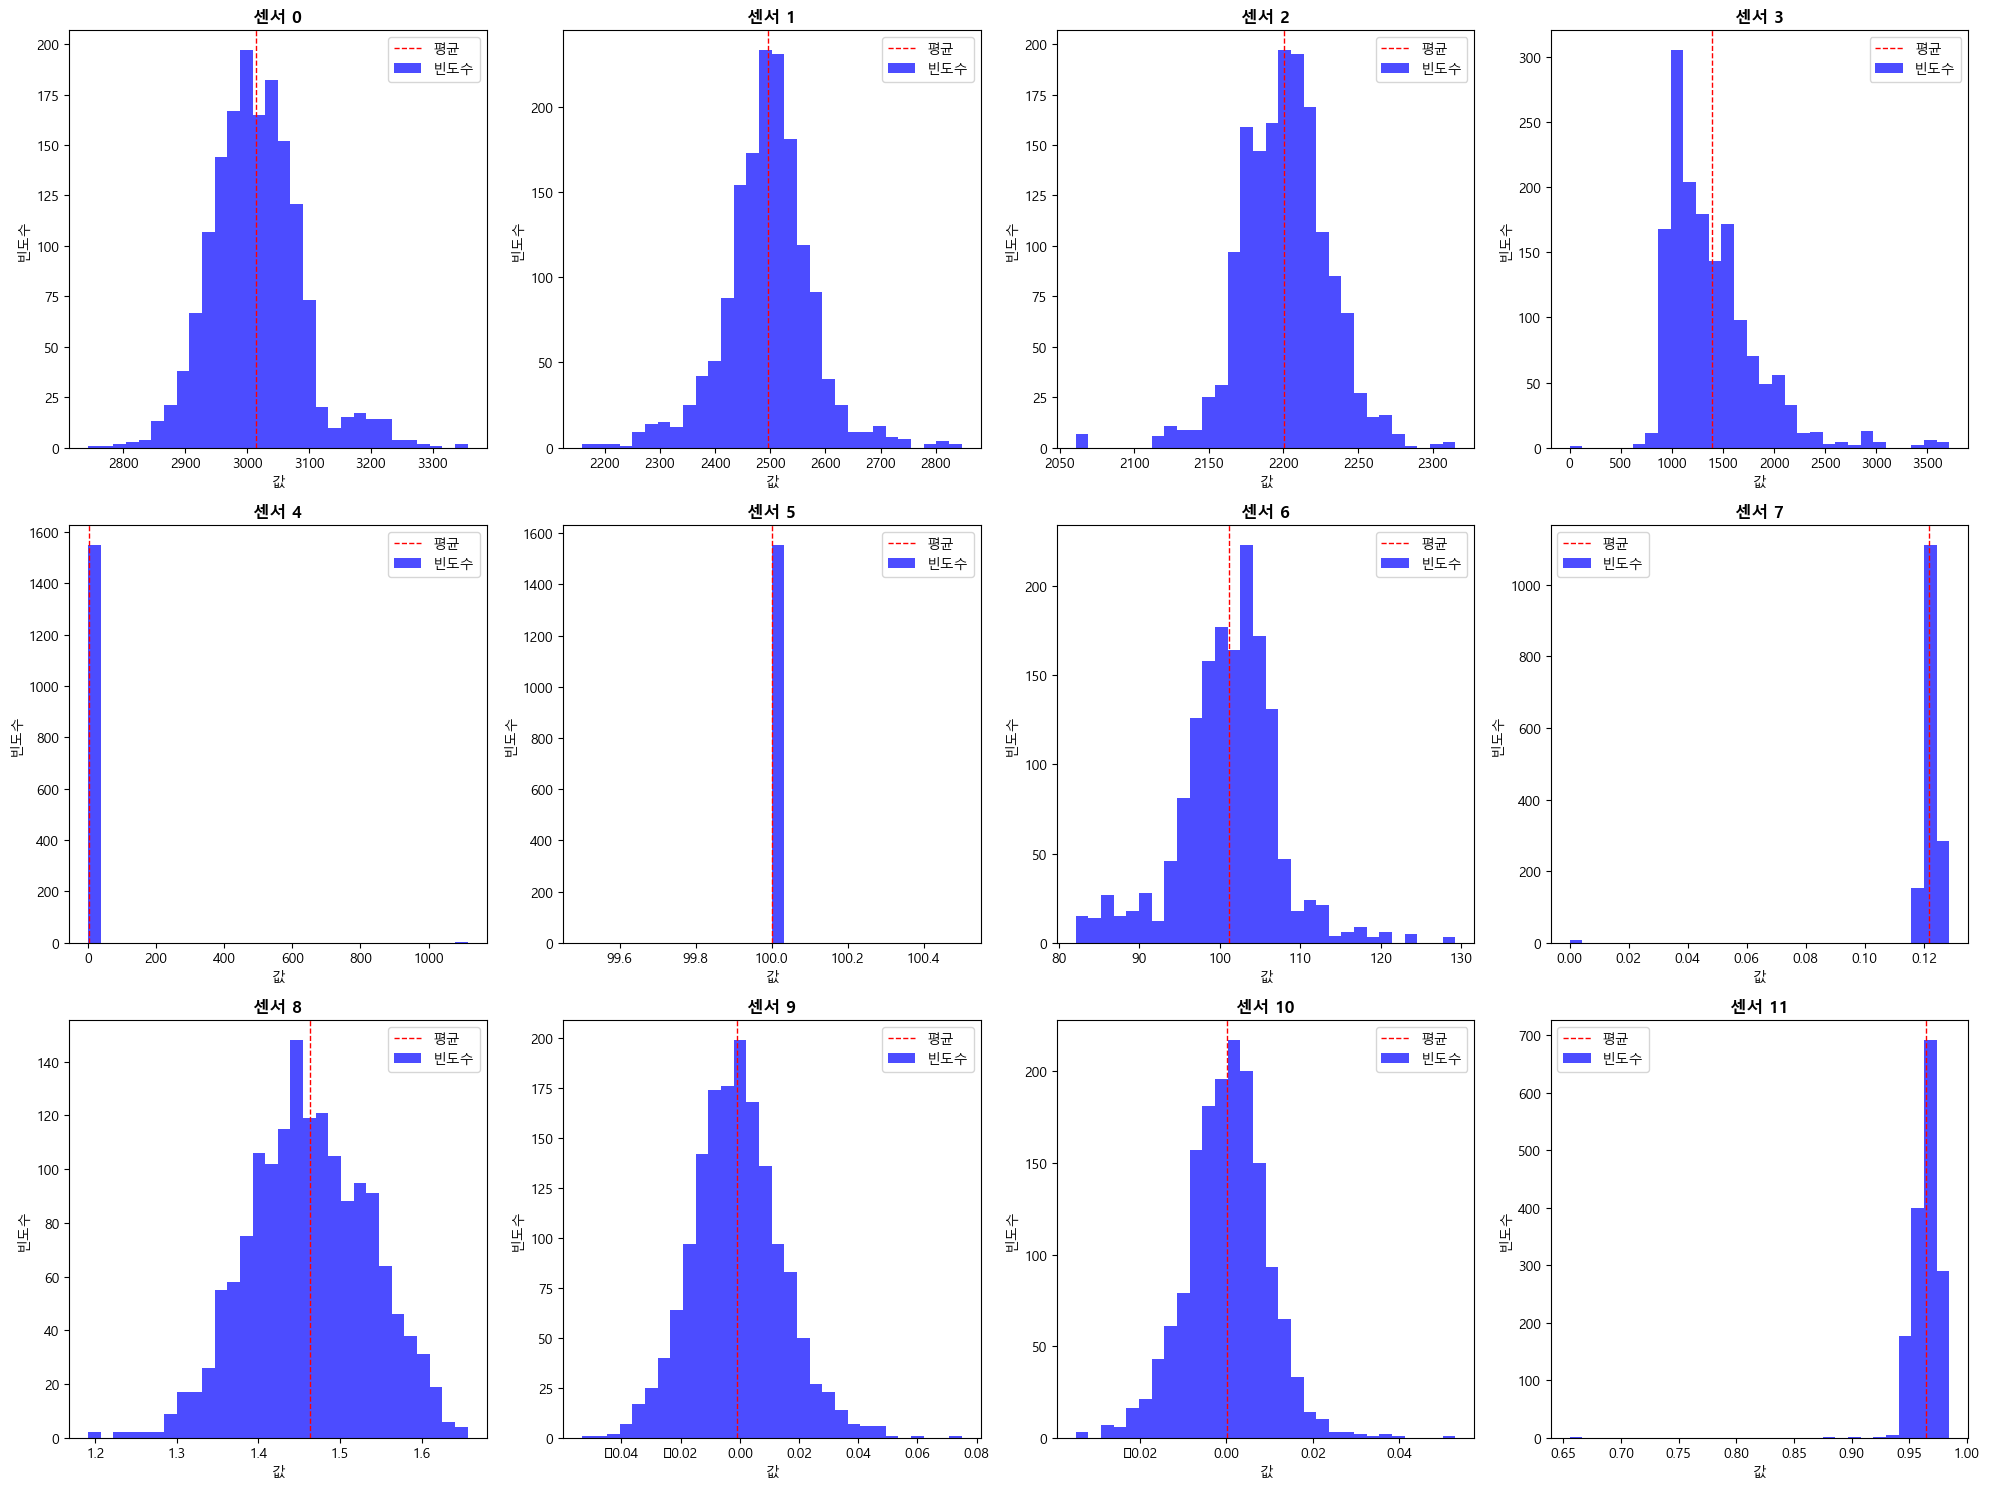

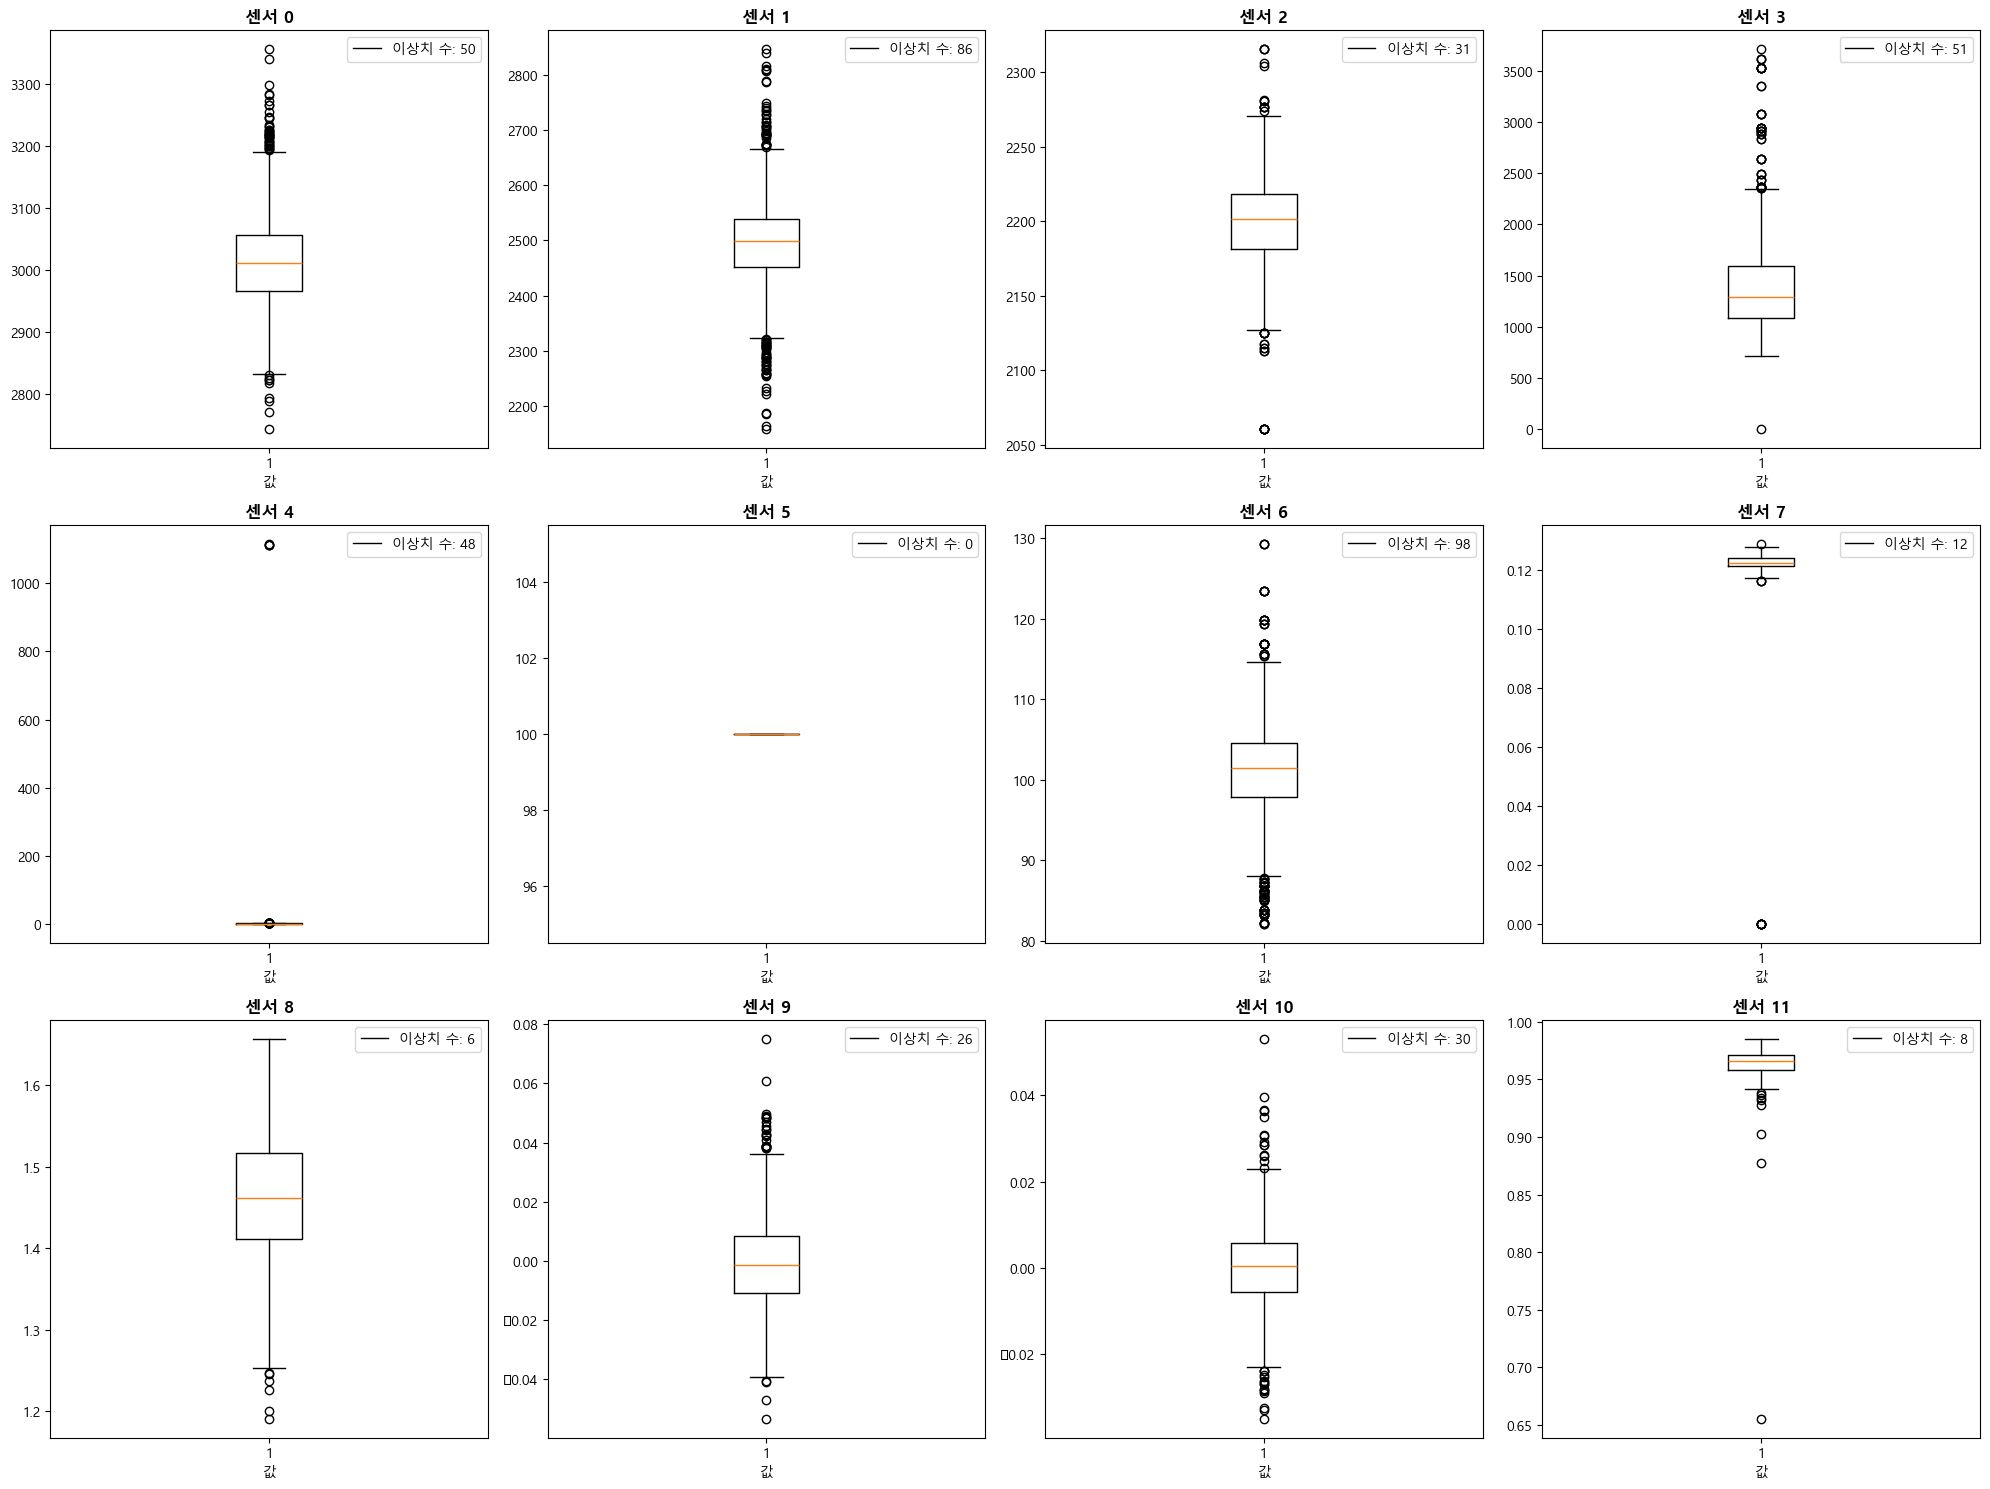

In [26]:
# 6. 데이터 분포 시각화

# 한글
plt.rc('font', family='Malgun Gothic')

# 샘플로 12개 특성의 분포를 히스토그램으로 시각화
sample_cols = numeric_features.columns[:12]

fig, axes = plt.subplots(3, 4, figsize=(20, 15)) # 3행 4열 서브플롯
axes = axes.ravel()

for i, col in enumerate(sample_cols):
    data = numeric_features[col].dropna()

    axes[i].hist(data, bins=30, color='blue', alpha=0.7)
    axes[i].set_title(f'센서 {col}', fontweight='bold')
    axes[i].set_xlabel('값')
    axes[i].set_ylabel('빈도수')

    # 평균선 표시
    axes[i].axvline(data.mean(), color='red', linestyle='dashed', linewidth=1)
    axes[i].legend(['평균', '빈도수'])
plt.tight_layout()
plt.show()

# 박스플롯 (이상치 시각화)
fig, axes = plt.subplots(3, 4, figsize=(20, 15)) # 3행 4열 서브플롯
axes = axes.ravel()

for i, col in enumerate(sample_cols):
    data = numeric_features[col].dropna()
    axes[i].boxplot(data, vert=True)
    axes[i].set_title(f'센서 {col}', fontweight='bold')
    axes[i].set_xlabel('값')

    # Q1, Q3, IQR 계산
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 범위 계산
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data < lower) | (data > upper)].count()
    axes[i].legend([f'이상치 수: {outliers}'])

plt.tight_layout()
plt.show()

# 결론 : 특성마다 분포가 다름 (정규분포, 치우친 분포 등), 이상치 존재 -> 많은 양이라고 생각되지 않음 -> 제거보다는 유지, robust scaling 고려

타겟과 상관관계가 높은 특성:
59     0.155796
103    0.151203
510    0.131593
348    0.130180
158    0.121258
431    0.120851
293    0.114494
111    0.113950
434    0.112116
430    0.110067
435    0.109067
21     0.108488
28     0.107252
436    0.106910
85     0.103559
129    0.103373
210    0.102545
298    0.102519
163    0.100330
124    0.093994
Name: Pass/Fail, dtype: float64


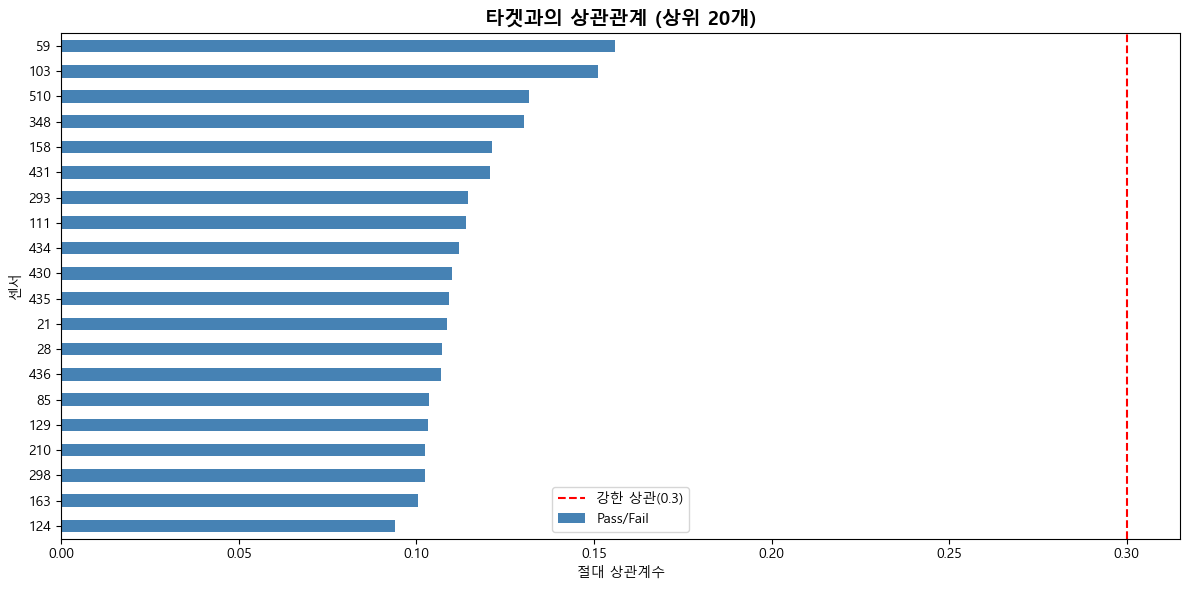

In [ ]:
# 7. 상관관계 분석

# 타겟 변환
df[target_col] = df[target_col].map({-1: 0, 1: 1}) # -1: 정상(0), 1: 불량(1)

# 숫자 특성 + 타겟
data_with_target = pd.concat([numeric_features, df[target_col]], axis=1)

# 타겟과 상관관계 계산
correlations = data_with_target.corr()[target_col].drop(target_col)
correlations_sorted = correlations.abs().sort_values(ascending=False)

print(f'타겟과 상관관계가 높은 특성:\n{correlations_sorted.head(20)}')

# 그래프로 보기
plt.figure(figsize=(12, 6))
correlations_sorted.head(20).plot(kind='barh', color='steelblue')
plt.title('타겟과의 상관관계 (상위 20개)', fontsize=14, fontweight='bold')
plt.xlabel('절대 상관계수')
plt.ylabel('센서')
plt.gca().invert_yaxis()
plt.axvline(0.3, color='red', linestyle='--', label='강한 상관(0.3)')
plt.legend()
plt.tight_layout()
plt.show()

# 결론 : 타겟과 상관관계가 높은 특성은 거의 없음 (최대 0.15) -> 복잡한 패턴 학습 필요 -> 랜덤포레스트, 그래디언트 부스팅, 신경망 등 고려

# 전처리 계획 수립

---

## 데이터 탐색 결과 요약

### 데이터 기본 정보
- **샘플 수**: 1,567개
- **특성 수**: 591개
- **타겟**: Pass/Fail
- **타겟 분포**: 
  - 정상: 1,463개 (93.4%)
  - 불량: 104개 (6.6%)

---

## 발견된 문제들

### 문제 1: 결측치
- **비율**: 4.52%
- **영향**: 대부분 센서에 골고루 분포
- **심각도**: 낮음

### 문제 2: 상수 특성
- **개수**: 115개 (19.5%)
- **영향**: 학습에 도움 안 됨
- **심각도**: 중간

### 문제 3: 스케일 차이
- **범위**: 0.00 ~ 37,943.00
- **영향**: 모델이 큰 값에만 집중
- **심각도**: 높음

### 문제 4: 클래스 불균형
- **비율**: 93.4% vs 6.6%
- **영향**: Accuracy 함정
- **심각도**: 높음

### 문제 5: 약한 상관관계
- **최고값**: 0.156
- **의미**: 복잡한 비선형 패턴
- **영향**: 단순 모델로는 한계

---

## 전처리 계획

### 1단계: 결측치 처리
**방법**: 중앙값(median)으로 대체

**이유**:
- 평균보다 이상치에 강함
- 센서 데이터에 적합

### 2단계: 상수 특성 제거
**방법**: 115개 컬럼 제거

**이유**
 - 모든 값이 같아 정보 없음
 - 계산 낭비

### 3단계: 스케일링
**방법**: StandardScaler

**이유**: 
 - 스케일 차이 극심(inf배)
 - 모든 특성을 동등하게
 - Z-score 정규화(평균0, 표준편차1)

### 모델 학습시 주의사항
 - 평가: Accuracy, Precision, Recall, F1-score 모두 확인
 - Recall(불량품 놓치지않기!)
